In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
preds = np.load('results/informer_ETTh2ms1f2_ftms_sl1152_ll1152_pl576_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
trues = np.load('results/informer_ETTh2ms1f2_ftms_sl1152_ll1152_pl576_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
metrics = np.load('results/informer_ETTh2ms1f2_ftms_sl1152_ll1152_pl576_dm512_nh8_el3_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')
# preds.shape, trues.shape, metrics.shape
print(metrics)

[0.16309348 0.05189015 0.22779408 0.5007327  8.757707  ]


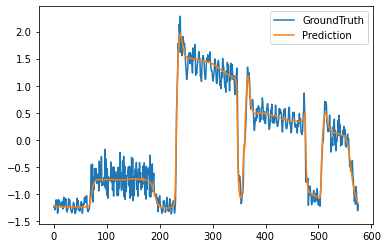

In [27]:
plt.figure()
plt.plot(trues[0, :, 0], label='GroundTruth')
plt.plot(preds[0, :, 0], label='Prediction')
plt.legend()
plt.savefig('11848.png')
plt.show()

In [30]:
import pandas as pd
data = pd.read_csv('data/ETT/archxixia_ms.csv')
data.head()

,date,OT
0,1949/1/1 8:00,112
1,1949/2/1 8:00,118
2,1949/3/1 8:00,132
3,1949/4/1 8:00,129
4,1949/5/1 8:00,121


In [32]:
import torch
import torch.nn as nn
x = torch.randn(1,7)
linear = nn.Linear(7, 512)
print(linear(x).shape)

torch.Size([1, 512])


In [40]:
x = torch.tensor([[[1,2,3],[4,5,6],[7,8,9]]])
x = x.numpy()
print(x)
print(x.shape)

[[[1 2 3]
  [4 5 6]
  [7 8 9]]]


KeyboardInterrupt: 

In [39]:
print(x[0,1,0])
print(x[0,:,1])

4
[2 5 8]


# ************************************************* 实现self-attention **********************************************************************

In [41]:
import torch

In [54]:
# 三个输入，每个输入是四维
x = [[1,0,1,0],
     [0,2,0,2],
     [1,1,1,1]]

x = torch.tensor(x, dtype=torch.float32)
print(x.shape)

torch.Size([3, 4])


In [43]:
# 初始化权重
# 目标得到quary，key，value是(1,3)维的，x.shape>>(1,4),权重shape即为(4,3)
w_key = [
    [0,0,1],
    [1,1,0],
    [0,1,0],
    [1,1,0]
]

w_query = [
  [1, 0, 1],
  [1, 0, 0],
  [0, 0, 1],
  [0, 1, 1]
]
w_value = [
  [0, 2, 0],
  [0, 3, 0],
  [1, 0, 3],
  [1, 1, 0]
]

w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

In [59]:
# 获取key、query、value
# @是两个矩阵相乘
keys = x@w_key
querys = x@w_query
values = x@w_value

# 注意每个输入对应的qi, ki, vi都是行向量，形状为（1，3)
print(keys)
# print(len(keys))  #3
# print(keys.T)
# tensor([[0., 1., 1.],
#         [4., 4., 0.],
#         [2., 3., 1.]])
print(querys)
# tensor([[1., 0., 2.],
#         [2., 2., 2.],
#         [2., 1., 3.]])
print(values)
# tensor([[1., 2., 3.],
#         [2., 8., 0.],
#         [2., 6., 3.]])

3
tensor([[1., 0., 2.],
        [2., 2., 2.],
        [2., 1., 3.]])
tensor([[1., 2., 3.],
        [2., 8., 0.],
        [2., 6., 3.]])


In [60]:
# 计算注意力分数
attn_scores = querys@keys.T
# 得到的内积是对称的
print(attn_scores)

# tensor([[ 2.,  4.,  4.],  # attention scores from Query 1
#         [ 4., 16., 12.],  # attention scores from Query 2
#         [ 4., 12., 10.]]) # attention scores from Query 3

tensor([[ 2.,  4.,  4.],
        [ 4., 16., 12.],
        [ 4., 12., 10.]])


ValueError: only one element tensors can be converted to Python scalars

In [48]:
# 计算softmax
from torch.nn.functional import softmax
# attn_scores_softmax = softmax(attn_scores, dim=1)

# 经过softmax处理之后是非对称的
attn_scores_softmax = [
  [0.0, 0.5, 0.5],
  [0.0, 1.0, 0.0],
  [0.0, 0.9, 0.1]
]
"""
[0.0, 0.5, 0.5]---output1对应的权重
[0.0, 1.0, 0.0]---output2对应的权重
[0.0, 0.9, 0.1]---output3对应的权重

output1 = 0*v1 + 0.5*v2 + 0.5*v3
        = 0*[1., 2., 3.]+0.5*[2., 8., 0.]+0.5*[2., 6., 3.]
        =[2,7,1.5]

output2 = 0*v1 + 1*v2 + 0*v3
        = 0*[1., 2., 3.]+1*[2., 8., 0.]+0*[2., 6., 3.]
        =[2,8,0]
"""

attn_scores_softmax = torch.tensor(attn_scores_softmax)

In [58]:
# 将分数乘以values
weighted_values = values[:,None]*attn_scores_softmax.T[:,:,None]

print(values[:,None])
print(attn_scores_softmax.T[:,:,None])
print(weighted_values.shape)
# weighted_values
# tensor([[[0.0000, 0.0000, 0.0000],
#          [0.0000, 0.0000, 0.0000],
#          [0.0000, 0.0000, 0.0000]],
#
#         [[1.0000, 4.0000, 0.0000],
#          [2.0000, 8.0000, 0.0000],
#          [1.8000, 7.2000, 0.0000]],
#
#         [[1.0000, 3.0000, 1.5000],
#          [0.0000, 0.0000, 0.0000],
#          [0.2000, 0.6000, 0.3000]]])

tensor([[[1., 2., 3.]],

        [[2., 8., 0.]],

        [[2., 6., 3.]]])
tensor([[[0.0000],
         [0.0000],
         [0.0000]],

        [[0.5000],
         [1.0000],
         [0.9000]],

        [[0.5000],
         [0.0000],
         [0.1000]]])
torch.Size([3, 3, 3])


In [50]:
# 对权重化的values求和
outputs = weighted_values.sum(dim=0)
outputs
# tensor([[2.0000, 7.0000, 1.5000],  # Output 1
#         [2.0000, 8.0000, 0.0000],  # Output 2
#         [2.0000, 7.8000, 0.3000]]) # Output 3

tensor([[2.0000, 7.0000, 1.5000],
        [2.0000, 8.0000, 0.0000],
        [2.0000, 7.8000, 0.3000]])